In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from datascience import *
import numpy as np
from scipy.spatial.distance import cosine
import gensim #topic modeling and word embedding 
import nltk
from string import punctuation

# Word Embedding

This lesson is designed to explore features of word embeddings described by Ben Schmidt in his blog post <a href="http://bookworm.benschmidt.org/posts/2015-10-30-rejecting-the-gender-binary.html">"Rejecting the Gender Binary"</a>.

The primary corpus we use consists of the <a href="http://txtlab.org/?p=601">150 English-language novels</a> made available by the .txtLab at McGill. We also look at a <a href="http://ryanheuser.org/word-vectors-1/">Word2Vec model trained on the ECCO-TCP corpus</a> of 2,350 eighteenth-century literary texts made available by Ryan Heuser. (I have shortened the number of terms in the model by half in order to conserve memory.)

For background on Word2Vec's mechanics, I suggest this <a href="https://www.tensorflow.org/versions/r0.8/tutorials/word2vec/index.html">brief tutorial</a> by Google, especially the sections "Motivation," "Skip-Gram Model," and "Visualizing."

We'll read in Andrew Piper's corpus we used in our Topic Modeling notebook:

In [6]:
metadata_tb = Table.read_table('../09-Topic-Modeling/data/txtlab_Novel150_English.csv')

fiction_path = '../09-Topic-Modeling/data/txtlab_Novel150_English/'

novel_list = []

# Iterate through filenames in metadata table
for filename in metadata_tb['filename']:
    
    # Read in novel text as single string, make lowercase
    with open(fiction_path + filename, 'r') as file_in:
        novel = file_in.read()
    
    # Add novel text as single string to master list
    novel_list.append(novel)

---

# Pre-Processing

Word2Vec learns about the relationships among words by observing them in context. We'll need to tokenize the words in our corpus while retaining sentence boundaries. Since novels were imported as single strings, we'll first use <i>sent_tokenize</i> to divide them into sentences, and second, we'll split each sentence into its own list of words.

We'll use `nltk`'s sentence tokenizer:

In [7]:
from nltk.tokenize import sent_tokenize

Due to memory and time constraints we'll use our quick and dirty tokenizer:

In [8]:
def fast_tokenize(text):
    
    # Iterate through text removing punctuation characters
    no_punct = "".join([char for char in text if char not in punctuation])
    
    # Split text over whitespace into list of words
    tokens = no_punct.split()
    
    return tokens

First get the sentences:

In [9]:
sentences = [sentence for novel in novel_list for sentence in sent_tokenize(novel)]

Now the words:

In [10]:
words_by_sentence = [fast_tokenize(sentence.lower()) for sentence in sentences]

We'll double check that we don't have any empty sentences:

In [11]:
words_by_sentence = [sentence for sentence in words_by_sentence if sentence != []]

We should now have a `list` of `list`s with sentences and words:

In [12]:
words_by_sentence[:2]

[['author’s',
  'introduction',
  'my',
  'dog',
  'had',
  'made',
  'a',
  'point',
  'on',
  'a',
  'piece',
  'of',
  'fallowground',
  'and',
  'led',
  'the',
  'curate',
  'and',
  'me',
  'two',
  'or',
  'three',
  'hundred',
  'yards',
  'over',
  'that',
  'and',
  'some',
  'stubble',
  'adjoining',
  'in',
  'a',
  'breathless',
  'state',
  'of',
  'expectation',
  'on',
  'a',
  'burning',
  'first',
  'of',
  'september'],
 ['it',
  'was',
  'a',
  'false',
  'point',
  'and',
  'our',
  'labour',
  'was',
  'vain',
  'yet',
  'to',
  'do',
  'rover',
  'justice',
  'for',
  'he’s',
  'an',
  'excellent',
  'dog',
  'though',
  'i',
  'have',
  'lost',
  'his',
  'pedigree',
  'the',
  'fault',
  'was',
  'none',
  'of',
  'his',
  'the',
  'birds',
  'were',
  'gone',
  'the',
  'curate',
  'showed',
  'me',
  'the',
  'spot',
  'where',
  'they',
  'had',
  'lain',
  'basking',
  'at',
  'the',
  'root',
  'of',
  'an',
  'old',
  'hedge']]

---

# Word2Vec

### Word Embeddings
Word2Vec is the most prominent word embedding algorithm. Word embedding generally attempts to identify semantic relationships between words by observing them in context.

Imagine that each word in a novel has its meaning determined by the ones that surround it in a limited window. For example, in Moby Dick's first sentence, “me” is paired on either side by “Call” and “Ishmael.” After observing the windows around every word in the novel (or many novels), the computer will notice a pattern in which “me” falls between similar pairs of words to “her,” “him,” or “them.” Of course, the computer had gone through a similar process over the words “Call” and “Ishmael,” for which “me” is reciprocally part of their contexts.  This chaining of signifiers to one another mirrors some of humanists' most sophisticated interpretative frameworks of language.

The two main flavors of Word2Vec are CBOW (Continuous Bag of Words) and Skip-Gram, which can be distinguished partly by their input and output during training. Skip-Gram takes a word of interest as its input (e.g. "me") and tries to learn how to predict its context words ("Call","Ishmael"). CBOW does the opposite, taking the context words ("Call","Ishmael") as a single input and tries to predict the word of interest ("me").

In general, CBOW is is faster and does well with frequent words, while Skip-Gram potentially represents rare words better.

### Word2Vec Features
<ul>
<li>`size`: Number of dimensions for word embedding model</li>
<li>`window`: Number of context words to observe in each direction</li>
<li>`min_count`: Minimum frequency for words included in model</li>
<li>`sg` (Skip-Gram): '0' indicates CBOW model; '1' indicates Skip-Gram</li>
<li>`alpha`: Learning rate (initial); prevents model from over-correcting, enables finer tuning</li>
<li>`iterations`: Number of passes through dataset</li>
<li>`batch_words`: Number of words to sample from data during each pass</li>
</ul>

Note: cell below uses default value for each argument

## Training

We've gotten accustomed to training powerful models in Python with one line of code, why stop now?

In [13]:
model = gensim.models.Word2Vec(words_by_sentence, size=100, window=5, \
                               min_count=5, sg=0, alpha=0.025, iter=5, batch_words=10000)

## Embeddings

We can return the actual high-dimensional vector by simply indexing the model with the word as the key:

In [14]:
model['whale']

array([ -1.79214776e+00,  -2.41471738e-01,   2.10318685e-01,
        -4.52885717e-01,  -1.15805656e-01,   1.77337539e+00,
        -3.03150535e+00,   4.28103864e-01,  -1.52845716e+00,
         1.25889230e+00,  -1.51829875e+00,  -8.95684481e-01,
        -1.38302457e+00,   3.33670706e-01,  -4.37399060e-01,
        -1.34843898e+00,   8.73876870e-01,  -9.74969193e-02,
         2.29718900e+00,  -2.58782125e+00,  -4.88136917e-01,
         1.49237227e+00,   7.45508850e-01,   7.57842898e-01,
        -5.57166748e-02,  -1.42830920e+00,   7.36897826e-01,
         5.57274640e-01,  -9.04805243e-01,  -2.53760368e-01,
         4.03131902e-01,  -1.28032565e-02,   6.95199192e-01,
         6.18007779e-01,   2.03834221e-01,   2.98530400e-01,
        -8.06178600e-02,   1.02990258e+00,   1.40192699e+00,
         7.95101166e-01,   2.92038381e-01,   3.57670814e-01,
         8.22397113e-01,  -2.90182158e-02,   2.49368429e-01,
         2.93059087e+00,  -5.74906528e-01,  -1.11725628e+00,
        -1.31183147e-01,

`gensim` comes with some handy methods to analyze word relationships. `similarity` will give us a number from 0-1 based on how similar two words are. If this sounds like cosine similarity for words, you'd be right! It just takes the cosine similarity of these high dimensional vectors:

In [15]:
model.similarity('sense','sensibility')

0.66902326306375404

We can also find cosine distance between two clusters of word vectors. Each cluster is measured as the mean of its words:

In [16]:
model.n_similarity(['sense','sensibility'],['whale','harpoon'])

0.13130881423451232

We can find words that don't belong with `doesnt_match`. It finds the mean vector of the words in the `list`, and identifies the furthest away:

In [17]:
model.doesnt_match(['pride','prejudice', 'harpoon'])

'harpoon'

The most famous implementation of this vector math is semantics. What happens if we take:

$$King - Man + Woman = $$

In [18]:
model.most_similar(positive=['woman', 'king'], negative=['man'])

[('princess', 0.7520204782485962),
 ('queen', 0.7295618057250977),
 ('duke', 0.7267670631408691),
 ('saint', 0.6838366985321045),
 ('duchess', 0.6415068507194519),
 ('earl', 0.6384197473526001),
 ('chevalier', 0.6375558376312256),
 ('emperor', 0.6357474327087402),
 ('abbot', 0.6285681128501892),
 ('marquis', 0.6245969533920288)]

Schmidt looked at words associated with male and female pronouns to investigate gender. Let's try take all the female pronouns and subtracting the male pronouns:

In [19]:
model.most_similar(positive=['she','her','hers','herself'], negative=['he','him','his','himself'])

[('lovely', 0.5188531279563904),
 ('girlish', 0.4782034754753113),
 ('beautiful', 0.4728282392024994),
 ('maiden', 0.45408549904823303),
 ('sweet', 0.44941699504852295),
 ('beauty', 0.43647971749305725),
 ('miss', 0.42681968212127686),
 ('innocent', 0.40955257415771484),
 ('roses', 0.40506401658058167),
 ('loveliness', 0.402911901473999)]

And the opposite:

In [20]:
model.most_similar(positive=['he','him','his','himself'], negative=['she','her','hers','herself'])

[('realestate', 0.4544639587402344),
 ('bill', 0.44785791635513306),
 ('clerk', 0.44316989183425903),
 ('commissioner', 0.4394550323486328),
 ('horse', 0.43853244185447693),
 ('captain', 0.42837703227996826),
 ('steward', 0.4281284511089325),
 ('mate', 0.4182766079902649),
 ('moby', 0.41797536611557007),
 ('buck', 0.4112522006034851)]

How about together (*genderless* in Schmidt's sense)?

In [21]:
model.most_similar(positive=['she','her','hers','herself','he','him','his','himself'], topn=50)

[('eugenia', 0.6237800121307373),
 ('itself', 0.6033990383148193),
 ('edgar', 0.5948238372802734),
 ('them', 0.5922368764877319),
 ('adeline', 0.5694077610969543),
 ('margaret', 0.5664571523666382),
 ('aileen', 0.5589945316314697),
 ('it', 0.5569705963134766),
 ('indiana', 0.5556083917617798),
 ('eleanor', 0.5517871379852295),
 ('carrie', 0.5502529740333557),
 ('camilla', 0.5474895238876343),
 ('constraint', 0.5338672995567322),
 ('illtemper', 0.5330542325973511),
 ('valancourt', 0.5275212526321411),
 ('maggie', 0.5274403691291809),
 ('leonora', 0.5271130800247192),
 ('isabel', 0.5262618064880371),
 ('amy', 0.5253405570983887),
 ('antonia', 0.5240936279296875),
 ('rhoda', 0.522874116897583),
 ('catherine', 0.5203244090080261),
 ('pericles', 0.5196587443351746),
 ('algernon', 0.515427827835083),
 ('her—she', 0.5124632120132446),
 ('belinda', 0.5121718049049377),
 ('aspasia', 0.5103188157081604),
 ('me', 0.5080291032791138),
 ('rebecca', 0.5079909563064575),
 ('erica', 0.5073215961456299

---

# Homework

Use the `most_similar` method to find the tokens nearest to 'car' in our model. Do the same for 'motorcar'.

In [43]:
# only do this
model.most_similar(positive=['car'], topn=50)

[('wagon', 0.8371553421020508),
 ('coach', 0.8251215815544128),
 ('cart', 0.8169521689414978),
 ('cab', 0.8096737861633301),
 ('chaise', 0.8008595108985901),
 ('buggy', 0.7993342280387878),
 ('sled', 0.7952866554260254),
 ('team', 0.7943257689476013),
 ('boat', 0.7840741872787476),
 ('vehicle', 0.7702536582946777),
 ('ladder', 0.7662621736526489),
 ('hansom', 0.7630524039268494),
 ('steamer', 0.7622679471969604),
 ('waggon', 0.7544130682945251),
 ('barn', 0.7534997463226318),
 ('carriage', 0.7529597878456116),
 ('stable', 0.7521263360977173),
 ('courtyard', 0.7452982664108276),
 ('dogcart', 0.7430658936500549),
 ('gig', 0.7415716648101807),
 ('canoe', 0.7367882132530212),
 ('skiff', 0.7335672378540039),
 ('yard', 0.7324950695037842),
 ('fence', 0.7304226756095886),
 ('barracks', 0.727343738079071),
 ('sleigh', 0.725430965423584),
 ('tent', 0.7249712347984314),
 ('stables', 0.7227667570114136),
 ('chariot', 0.7225255966186523),
 ('gate', 0.7216490507125854),
 ('rear', 0.7207760214805603

In [44]:
model.most_similar(positive=['motorcar'], topn=50)

[('dab', 0.7267305850982666),
 ('cockleshell', 0.7088605165481567),
 ('knothole', 0.7072004079818726),
 ('parao', 0.7060015201568604),
 ('haystack', 0.7047387957572937),
 ('locomotive', 0.7033783197402954),
 ('threemasted', 0.7019756436347961),
 ('limekiln', 0.7000597715377808),
 ('tassel', 0.7000576853752136),
 ('chunk', 0.7000094056129456),
 ('syllabub', 0.6997818946838379),
 ('roosted', 0.6963580846786499),
 ('particoloured', 0.6947195529937744),
 ('gorget', 0.6934241652488708),
 ('sark', 0.692436695098877),
 ('pilothouse', 0.6904045939445496),
 ('haircut', 0.6889897584915161),
 ('deathtrap', 0.6876357793807983),
 ('hostel', 0.6872018575668335),
 ('cowboy', 0.6815052628517151),
 ('truss', 0.6809514760971069),
 ('noodle', 0.6796009540557861),
 ('smallclothes', 0.6793582439422607),
 ('locker', 0.6788920164108276),
 ('cyclops', 0.6788015365600586),
 ('connemara', 0.6785188913345337),
 ('batteringram', 0.6783176064491272),
 ('bug', 0.6780466437339783),
 ('papyrus', 0.6777780055999756),


What characterizes each word in our corpus? Does this make sense?

Vector addition and subtraction can be thought of in terms of analogy. From the example above: 'man' is to 'king' as 'woman' is to '???'. Use the `most_similar` method to find: 'paris' is to 'france' as 'london' is to '???'

What has our model learned about nation-states?

Perform the canonic Word2Vec addition again but leave out a term. Try 'king' - 'man', 'woman' - 'man', 'woman' + 'king'.

What do these indicate semantically?

---

## Visualization

We can use multi-dimensional scaling to visualize this space just like we did with the documents before. But there are a lot of words here, so let's limit it to 50 words from our female gendered subset:

In [23]:
her_tokens = [token for token,weight in model.most_similar(positive=['she','her','hers','herself'], \
                                                       negative=['he','him','his','himself'], topn=50)]

We need to get the vector from each word, just like above, and add that to a list:

In [24]:
vectors = [model[word] for word in her_tokens]    

We can then calculate pairwise the cosine distance:

In [25]:
from sklearn.metrics import pairwise
dist_matrix = pairwise.pairwise_distances(vectors, metric='cosine')

We'll use `MDS` to reduce the dimensions to two:

In [26]:
from sklearn.manifold import MDS
mds = MDS(n_components = 2, dissimilarity='precomputed')
embeddings = mds.fit_transform(dist_matrix)

Some fancy `matplotlib` code...

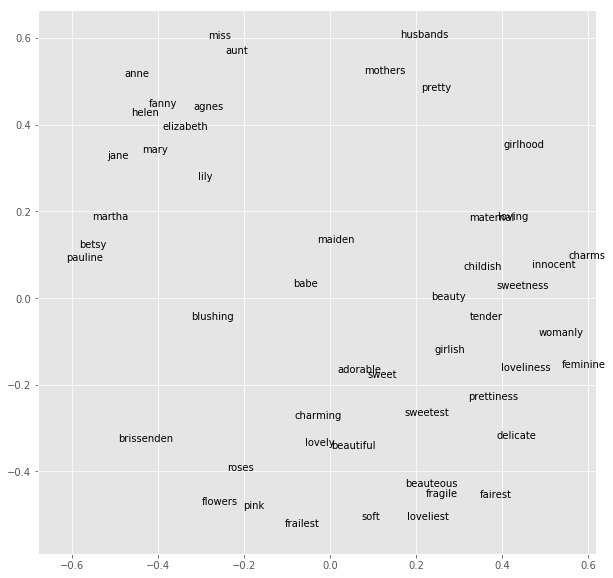

In [27]:
_, ax = plt.subplots(figsize=(10,10))
ax.scatter(embeddings[:,0], embeddings[:,1], alpha=0)
for i in range(len(vectors)):
    ax.annotate(her_tokens[i], ((embeddings[i,0], embeddings[i,1])))

What kinds of semantic relationships exist in the diagram above? Are there any words that seem out of place? How do you think they go there?

---

# Saving/Loading Models

We can save the model as a `.txt` file with the `save_word2vec_format` method:

In [28]:
model.wv.save_word2vec_format('word2vec.txtalb_Novel150_English.txt')

To load up a model, we just ask `gensim`. Here's a model trained on Eighteenth Century Collections Online corpus (~2500 texts) made available by Ryan Heuser: http://ryanheuser.org/word-vectors-1/

In [29]:
ecco_model = gensim.models.KeyedVectors.load_word2vec_format('data/word2vec.ECCO-TCP.txt')

In [30]:
ecco_model.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7854657173156738),
 ('emperor', 0.7523162364959717),
 ('prince', 0.7436755895614624),
 ('princess', 0.713316798210144),
 ('conqueror', 0.7111818194389343),
 ('regent', 0.7088087797164917),
 ('empress', 0.6977599263191223),
 ('sultan', 0.6729022264480591),
 ('confessor', 0.6569845676422119),
 ('duke', 0.6366889476776123)]

In [31]:
ecco_model.most_similar(positive=['she','her','hers','herself'], negative=['he','him','his','himself'])

[("harriet's", 0.5708541870117188),
 ('softness', 0.5513930320739746),
 ('maiden', 0.5411286354064941),
 ("chloe's", 0.5403314828872681),
 ('lovely', 0.5320479869842529),
 ('coy', 0.5259038209915161),
 ('bewitching', 0.5255858898162842),
 ('soft', 0.5217857956886292),
 ('blushing', 0.5112706422805786),
 ('virgin', 0.5070083141326904)]

How does this differ from our novels model?

---

# Homework

Heuser's blog post explores an analogy in eighteenth-century thought that Riches are to Virtue what Learning is to Genius. How true is this in the ECCO-trained Word2Vec model? Is it true in the one we trained?

How might we compare word2vec models more generally?

---

# Alternative features for a classification model

This is really cool but what implications does this have for our model of language? Well, word embeddings are simply more precise features of what we've been trying to get at already. That means we can use them in the machine learning models we've been building.

Recall our DTM bag of words classifier:

In [32]:
import nltk
nltk.download("movie_reviews")

[nltk_data] Downloading package movie_reviews to /srv/app/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

In [33]:
from nltk.corpus import movie_reviews
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import shuffle

reviews = [movie_reviews.raw(fileid) for fileid in movie_reviews.fileids()]
judgements = [movie_reviews.categories(fileid)[0] for fileid in movie_reviews.fileids()]

np.random.seed(0)

X, y = shuffle(reviews, judgements, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# get tfidf values
tfidf = TfidfVectorizer()
tfidf.fit(X)
X_train_transformed = tfidf.transform(X_train)
X_test_transformed = tfidf.transform(X_test)

# build and test logit
logit_class = LogisticRegression(penalty='l2', C=1000)
logit_model = logit_class.fit(X_train_transformed, y_train)
logit_model.score(X_test_transformed, y_test)

0.87250000000000005

---

So how can we use word embeddings as features? Believe it or not, one of the most effective ways is to simply average each dimension of our embedding across all the words for a given document. Recall our w2v model for novels was trained for 100 dimensions. Creating the features for a specific document would entail first extracting the 100 dimensions for each word, then average each dimension across all words:

In [34]:
np.mean([model[w] for w in fast_tokenize(X[0]) if w in model], axis=0)

array([-0.86721265,  0.65927458,  0.38148916, -0.16515677, -0.74919486,
        0.35815531, -0.27271143, -0.24489492, -0.32403937, -0.03674171,
       -0.62859678,  0.14786351, -0.53284234,  0.50110048,  0.30629885,
       -0.84067529, -0.02939497, -0.50702965, -0.13977095, -0.27349269,
       -0.12764941, -0.1183802 , -0.08050266,  0.18223007,  0.38268563,
        0.21684456,  0.07963157, -0.72999072,  0.33881205,  0.41768461,
        0.01021805, -0.23146498, -0.0912041 , -0.2753835 , -0.01787647,
        0.00282279,  0.4731822 ,  0.24763599,  0.85679173, -0.11328914,
        0.03884919, -0.11634649,  0.51895231,  0.02116567, -0.20737293,
        0.49326611, -0.23798545,  0.34520626,  0.09478536, -0.66405344,
       -0.38279307, -0.0267011 ,  0.22683875, -0.08496095,  0.17393096,
        0.10487702,  0.61723161,  0.11805099, -0.02807419,  0.35033929,
        0.2892485 , -0.78541088, -0.34410492,  0.16266681, -0.36562636,
       -0.04642203, -0.38382554,  0.11305425,  0.025546  ,  0.01

This gives us a set `X` array with 100 features. We can write a function to do this for us for any given string:

In [35]:
def w2v_featurize(document, model):
    return np.mean([model[w] for w in fast_tokenize(document) if w in model], axis=0)

We can then featurize all of our documents:

In [36]:
X_train_w2v = [w2v_featurize(d, model) for d in X_train]
X_test_w2v = [w2v_featurize(d, model) for d in X_test]

We can fit and score the machine learning modle just as before:

In [37]:
logit_class = LogisticRegression(random_state=0, penalty='l2', C=1000)
logit_model = logit_class.fit(X_train_w2v, y_train)
logit_model.score(X_test_w2v, y_test)

0.78000000000000003

In [38]:
#neural networks not conclusive, but maybe accurate

What about Heuser's model?

In [39]:
X_train_w2v = [w2v_featurize(d, ecco_model) for d in X_train]
X_test_w2v = [w2v_featurize(d, ecco_model) for d in X_test]
logit_class = LogisticRegression(random_state=0, penalty='l2', C=1000)
logit_model = logit_class.fit(X_train_w2v, y_train)
logit_model.score(X_test_w2v, y_test)

0.77249999999999996

Cool! But wait, what if we wanted to know *why* the model was making decisions. If we ask for the most postive coefficients:

In [40]:
np.argsort(logit_model.coef_[0])[-10:]

array([77, 67, 88, 81, 15, 47, 57, 36, 90, 70])

And the negative:

In [41]:
np.argsort(logit_model.coef_[0])[:10]

array([97, 96, 49, 87,  0, 52, 84, 42, 43,  1])

These are the *indices* for the important features. ***But what are these features now?***

---

Note that using our novels w2v model was not as accurate as a BoW tfidf method. That should be expected given movie review language is likely ***VERY*** different from our novel corpus. And our novel corpus likely didn't even have entries for a lot of the words used in our movie reviews corpus.

For modern English, most people look for Stanford's [GloVe](https://nlp.stanford.edu/projects/glove/) model. This was trained on 6 billion tokens from Wikipedia and Gigaword! Quite a step up from 150 novels. Even the smallest model is a bit large to be working with on our cloud server, but using this model and the code below, you can see it's power:

```python
>>> os.system('python -m gensim.scripts.glove2word2vec -i glove.6B.100d.txt -o glove.6B.100d.w2v.txt')
>>> glove = gensim.models.KeyedVectors.load_word2vec_format('glove.6B.100d.w2v.txt')

>>> X_train_glove = [w2v_featurize(d, glove) for d in X_train]
>>> X_test_glove = [w2v_featurize(d, glove) for d in X_test]

>>> logit_class = LogisticRegression(random_state=0, penalty='l2', C=1000)
>>> logit_model = logit_class.fit(X_train_glove, y_train)
>>> logit_model.score(X_test_glove, y_test)

.8125
```

While this is not as accurate as our BoW *tfidf* method, there have been several applications and transformations of word embeddings that have proven to be more accurate than a BoW *tfidf* on general modern text corpora. And keep in mind, one of the most interesting parts of this is that it only uses 100 dimensions, i.e., we can get ~81% accuracy by reducing a movie review to only 100 different features (our BoW model had over 39000!).

In [42]:
X_train_transformed

<1600x39659 sparse matrix of type '<class 'numpy.float64'>'
	with 536995 stored elements in Compressed Sparse Row format>